# 🧠 EvoSwarm: Evolutionary Test-Time Optimization for LLM Agents

**EvoSwarm** is a lightweight experimental framework that tests whether evolutionary and swarm algorithms can improve reasoning performance **at inference time**, not just during training.  
It treats each episode as a micro-evolutionary arena where populations of prompt-and-hyperparameter “genomes” compete and adapt in real time.

---

## 🔍 Purpose
Traditional test-time scaling methods (e.g., reflection, self-consistency, tree-of-thought) explore reasoning space through sampling.  
EvoSwarm takes a different path: it **evolves** agent behavior using **Genetic Algorithms (GA)**, **Particle Swarm Optimization (PSO)**, and **MAP-Elites quality-diversity** — all operating *within* a single evaluation loop.

---

## ⚙️ Core Mechanisms
- 🧬 **Genetic mutation + crossover** on discrete “genes” (prompt patterns, heuristics).  
- 🌌 **PSO-style continuous tuning** of parameters like temperature, top-p, and retry limits.  
- 🎨 **MAP-Elites archive** to preserve diverse strategies and prevent premature convergence.  
- 🦋 **Step-time action swarm:** when stuck, multiple genomes propose actions and the system executes the one with the highest heuristic value.  
- 🧱 **Self-contained toy environment:** a 3-room text adventure (Start → Hall → LockedRoom → Treasure) that simulates decision-making under sparse rewards.

---

## 📊 Results (SmolLLM Test)

| Metric | Baseline | EvoSwarm | Δ |
|:--|--:|--:|--:|
| **Success Rate** | 0.15 | 0.25 | **+66%** |
| **Avg Steps** | 38.8 | 37.15 | –1.65 |
| **Avg Reward** | 0.151 | 0.271 | **+79%** |

EvoSwarm achieves **higher success and reward** while using fewer steps on average — even though both agents operate on the same tiny simulated world.

---

## 🧩 Interpretation
- The **GA/PSO population** dynamically shifts exploration–exploitation balance across runs.  
- **MAP-Elites** maintains strategy diversity, avoiding stagnation on unlucky seeds.  
- The **step-time swarm** adds lightweight parallel look-ahead that mimics ensemble reasoning.  

While the absolute rewards remain low (as expected in this minimal environment), the consistent edge shows that **inference-time evolution can guide an LLM’s reasoning trajectory** in ways reflection alone cannot.

---

## 🚀 Future Extensions
- Plug in real LLMs (e.g., `HuggingFaceTB/SmolLM3-Instruct`) or other open-weights models.  
- Extend environments (ALFWorld, MiniHack, text puzzles).  
- Compare against Tree-of-Thoughts, Reflexion, and ReAct baselines.  
- Measure compute-to-gain efficiency curves.

---

🧠 *EvoSwarm demonstrates that even small, compute-bounded evolutionary populations can yield measurable reasoning gains at test time — hinting at a new frontier of adaptive, self-optimizing inference.*



## 0) Runtime switches


In [ ]:

USE_REAL_LLM = True  # set True to use a real HF model as policy
MODEL_NAME = "HuggingFaceTB/SmolLM3-3B"  # or "HuggingFaceTB/SmolLM3-360M-Instruct"
MAX_NEW_TOKENS = 16
RANDOM_SEED = 42



## 1) Install & Imports


In [ ]:

import sys, subprocess, os, random, json, time, copy, math, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Dict, Any

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

if USE_REAL_LLM:
    try:
        import transformers  # noqa
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "transformers", "accelerate", "sentencepiece"])
    from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline



## 2) Toy Text IF Environment


In [ ]:

class ToyIF:
    def __init__(self):
        self.rooms = ["Start", "Hall", "LockedRoom"]
        self.pos = "Start"
        self.has_key = False
        self.door_locked = True
        self.treasure = True
        self.steps = 0
        self.done = False
        self.score = 0.0
        self.visited = set([self.pos])

    def obs(self):
        desc = []
        if self.pos == "Start":
            desc.append("You are in the Start room. There is an exit to the east.")
        elif self.pos == "Hall":
            desc.append("You are in the Hall. You see something shiny here. Exits: west, north.")
            if not self.has_key:
                desc.append("There is a key on the floor.")
        elif self.pos == "LockedRoom":
            desc.append("You are in a small room with a chest. Exits: south.")
            if self.door_locked:
                desc.append("The door to the south seems recently unlocked.")
            if self.treasure:
                desc.append("There is a treasure chest here.")
        return " ".join(desc)

    def reward_shaping(self):
        r = 0.0
        if self.pos not in self.visited:
            r += 0.05
            self.visited.add(self.pos)
        return r

    def step(self, action: str):
        self.steps += 1
        action = action.strip().lower()
        r = 0.0
        info = {}

        if action in ["look","examine room","observe"]:
            pass
        elif action in ["east","go east","move east"]:
            if self.pos == "Start":
                self.pos = "Hall"
            else:
                r -= 0.01
        elif action in ["west","go west","move west"]:
            if self.pos == "Hall":
                self.pos = "Start"
            else:
                r -= 0.01
        elif action in ["north","go north","move north"]:
            if self.pos == "Hall":
                if self.door_locked:
                    r -= 0.02
                    info["blocked"] = True
                else:
                    self.pos = "LockedRoom"
            else:
                r -= 0.01
        elif action in ["south","go south","move south"]:
            if self.pos == "LockedRoom":
                self.pos = "Hall"
            else:
                r -= 0.01
        elif action in ["take key","get key","pickup key"]:
            if self.pos == "Hall" and not self.has_key:
                self.has_key = True
                r += 0.1
            else:
                r -= 0.01
        elif action in ["unlock door","use key on door","open door"]:
            if self.pos == "Hall" and self.has_key and self.door_locked:
                self.door_locked = False
                r += 0.2
            else:
                r -= 0.01
        elif action in ["get treasure","take treasure","open chest","loot treasure"]:
            if self.pos == "LockedRoom" and not self.door_locked and self.treasure:
                self.treasure = False
                r += 1.0
                self.done = True
            else:
                r -= 0.01
        else:
            r -= 0.02

        r += self.reward_shaping()
        return self.obs(), r, self.done, info

    def reset(self):
        self.__init__()
        return self.obs()



## 3) Policy Sampler (Simulated + HF SmolLLM)


In [ ]:

ACTIONS = [
    "look","east","west","north","south","take key","unlock door","get treasure"
]

def _softmax(x, temp=1.0):
    x = np.array(x, dtype=np.float32)
    x = x / max(1e-8, temp)
    x = x - x.max()
    ex = np.exp(x)
    return ex / np.clip(ex.sum(), 1e-8, None)

def simulated_policy_scores(prompt_genes: Dict[str, Any], knobs: Dict[str, float], obs: str, history: List[str]):
    scores = {a: -0.05 for a in ACTIONS}
    if prompt_genes.get("examine_first", False):
        if "You are in" in obs and (len(history)==0 or history[-1] != "look"):
            scores["look"] += 0.2
    if "key on the floor" in obs and not prompt_genes.get("ignore_key", False):
        scores["take key"] += 0.3
    if "door" in obs:
        scores["unlock door"] += 0.1
    if "treasure" in obs:
        scores["get treasure"] += 0.2
    if prompt_genes.get("prefer_explore", True):
        if "Start room" in obs:
            scores["east"] += 0.15
        if "Hall" in obs:
            scores["north"] += 0.05
    if len(history) >= 2 and history[-1] == history[-2]:
        for a in scores:
            scores[a] -= 0.02
        scores["look"] += 0.05
    temp = float(max(0.05, knobs.get("temperature", 0.7)))
    top_p = float(knobs.get("top_p", 0.95))
    logits = [scores[a] for a in ACTIONS]
    probs = _softmax(logits, temp=temp)
    order = np.argsort(probs)[::-1]
    cum = 0.0; keep = []
    for idx in order:
        keep.append(idx)
        cum += probs[idx]
        if cum >= top_p: break
    mask = np.zeros_like(probs); mask[keep]=1
    probs = probs * mask
    s = probs.sum()
    probs = np.ones_like(probs)/len(probs) if s<=0 else probs/s
    return {a: float(probs[i]) for i,a in enumerate(ACTIONS)}

def sample_action_from_scores(scores: Dict[str,float]):
    actions = list(scores.keys())
    ps = np.array([scores[a] for a in actions], dtype=np.float32)
    ps /= ps.sum()
    return np.random.choice(actions, p=ps)

_HF_PIPELINE = None

def _ensure_hf_pipeline():
    global _HF_PIPELINE
    if _HF_PIPELINE is not None:
        return _HF_PIPELINE
    from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
    tok = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto")
    _HF_PIPELINE = pipeline("text-generation", model=model, tokenizer=tok)
    return _HF_PIPELINE

def _closest_action(text: str):
    t = text.strip().lower()
    for a in ACTIONS:
        if a in t:
            return a
    if "east" in t: return "east"
    if "west" in t: return "west"
    if "north" in t: return "north"
    if "south" in t: return "south"
    if "key" in t and ("take" in t or "get" in t or "pick" in t): return "take key"
    if ("unlock" in t or "open" in t) and "door" in t: return "unlock door"
    if ("treasure" in t or "chest" in t) and ("get" in t or "take" in t or "open" in t or "loot" in t): return "get treasure"
    if "look" in t or "examine" in t or "observe" in t: return "look"
    return "look"

def real_llm_policy(prompt_text: str, obs: str, history: List[str]) -> str:
    pipe = _ensure_hf_pipeline()
    sys_prompt = prompt_text.strip()
    user = (
        "You are playing a tiny text adventure. "
        "Return exactly one action string from this list:\n"
        f"{ACTIONS}\n\n"
        f"OBSERVATION: {obs}\n"
        f"HISTORY: {history[-3:]}\n"
        "Answer with only the action, no extra words."
    )
    prompt = sys_prompt + "\n\nUser:\n" + user + "\nAssistant:"
    out = pipe(
        prompt,
        max_new_tokens=MAX_NEW_TOKENS,
        do_sample=True,
        temperature=0.7,
        top_p=0.9
    )[0]["generated_text"]
    tail = out.split("Assistant:")[-1]
    return _closest_action(tail)



## 4) Genome + Evo (GA + PSO-lite + MAP-Elites)


In [ ]:

@dataclass
class Genome:
    prompt_genes: Dict[str, Any]
    knobs: Dict[str, float]
    id: int = field(default_factory=lambda: random.randint(0, 10**9))
    fitness: float = -1e9
    meta: Dict[str, Any] = field(default_factory=dict)

def random_genome():
    return Genome(
        prompt_genes={
            "examine_first": random.random()<0.7,
            "ignore_key": random.random()<0.1,
            "prefer_explore": random.random()<0.8
        },
        knobs={
            "temperature": float(np.clip(np.random.normal(0.7, 0.2), 0.05, 1.5)),
            "top_p": float(np.clip(np.random.normal(0.95, 0.05), 0.5, 1.0)),
            "retry_limit": int(np.clip(int(np.random.normal(2, 1)), 0, 5))
        }
    )

def mutate(g: Genome):
    c = copy.deepcopy(g)
    for k in list(c.prompt_genes.keys()):
        if random.random()<0.2:
            c.prompt_genes[k] = not c.prompt_genes[k]
    c.knobs["temperature"] = float(np.clip(c.knobs["temperature"] + np.random.normal(0,0.1), 0.05, 1.5))
    c.knobs["top_p"] = float(np.clip(c.knobs["top_p"] + np.random.normal(0,0.03), 0.5, 1.0))
    if random.random()<0.3:
        c.knobs["retry_limit"] = int(np.clip(c.knobs["retry_limit"] + np.random.choice([-1,1]), 0, 5))
    c.id = random.randint(0, 10**9); c.fitness = -1e9
    return c

def crossover(a: Genome, b: Genome):
    child = copy.deepcopy(a)
    for k in child.prompt_genes:
        if random.random()<0.5:
            child.prompt_genes[k] = b.prompt_genes[k]
    lam = random.random()
    child.knobs["temperature"] = float(lam*a.knobs["temperature"] + (1-lam)*b.knobs["temperature"])
    lam = random.random()
    child.knobs["top_p"] = float(lam*a.knobs["top_p"] + (1-lam)*b.knobs["top_p"])
    child.knobs["retry_limit"] = random.choice([a.knobs["retry_limit"], b.knobs["retry_limit"]])
    child.id = random.randint(0, 10**9); child.fitness = -1e9
    return child

class MAPElites:
    def __init__(self, bins=4):
        self.bins = bins
        self.archive = {}
    def _bin(self, exploration, tooluse):
        i = min(self.bins-1, int(exploration * self.bins))
        j = min(self.bins-1, int(tooluse * self.bins))
        return (i,j)
    def insert(self, genome: Genome, exploration: float, tooluse: float):
        key = self._bin(exploration, tooluse)
        cur = self.archive.get(key)
        if cur is None or genome.fitness > cur.fitness:
            self.archive[key] = copy.deepcopy(genome)
    def population(self):
        return [copy.deepcopy(g) for g in self.archive.values()]



## 5) Agents (Baseline + EvoSwarm)


In [ ]:

BASELINE_GENOME = Genome(
    prompt_genes={"examine_first": True, "ignore_key": False, "prefer_explore": True},
    knobs={"temperature": 0.7, "top_p": 0.95, "retry_limit": 2}
)

def run_episode_baseline(env: ToyIF, genome=BASELINE_GENOME, max_steps=40):
    obs = env.reset()
    total_r = 0.0
    history_obs = []
    actions_taken = []
    tool_use = 0
    deadlock = 0
    for t in range(max_steps):
        if USE_REAL_LLM:
            action = real_llm_policy("Baseline policy. Return only one action.", obs, history_obs)
        else:
            scores = simulated_policy_scores(genome.prompt_genes, genome.knobs, obs, history_obs[-2:])
            action = sample_action_from_scores(scores)
        if deadlock >= 3:
            action = "look"; deadlock = 0
        prev = total_r
        obs_next, r, done, info = env.step(action)
        total_r += r
        if action in ["unlock door","get treasure","take key","look"]:
            tool_use += 1
        deadlock = deadlock + 1 if abs(total_r - prev) < 1e-6 else 0
        actions_taken.append(action)
        history_obs.append(obs)
        obs = obs_next
        if done: break
    exploration_rate = len(env.visited)/3.0
    tool_use_rate = min(1.0, tool_use/10.0)
    return dict(reward=total_r, steps=env.steps, done=env.done,
                exploration=exploration_rate, tool_use=tool_use_rate,
                actions=actions_taken)

def ucb_select(pop, counts, values, total_plays, c=1.2):
    best, best_ucb = None, -1e9
    for g in pop:
        gid = g.id
        n = counts.get(gid, 0) + 1e-6
        q = values.get(gid, 0.0)
        u = q + c * math.sqrt(math.log(max(1,total_plays)) / n)
        if u > best_ucb:
            best_ucb, best = u, g
    return best

def heuristic_value(env: ToyIF, obs: str):
    v = 0.0
    v += 0.2 * (len(env.visited)-1)
    v += 0.2 if env.has_key else 0.0
    v += 0.2 if not env.door_locked else 0.0
    v += 0.3 if env.pos=="LockedRoom" else 0.0
    v += 0.5 if not env.treasure else 0.0
    return v

def run_episode_evoswarm(env: ToyIF, population: List[Genome], elites: MAPElites, max_steps=40, step_swarm_K=5):
    obs = env.reset()
    total_r = 0.0
    history_obs = []
    actions_taken = []
    tool_use = 0
    counts, values, plays = {}, {}, 0
    deadlock = 0

    for t in range(max_steps):
        plays += 1
        g = ucb_select(population, counts, values, plays, c=1.2)
        if USE_REAL_LLM:
            action = real_llm_policy("EvoSwarm policy. Return only one action.", obs, history_obs)
        else:
            scores = simulated_policy_scores(g.prompt_genes, g.knobs, obs, history_obs[-2:])
            action = sample_action_from_scores(scores)
        if deadlock >= 3:
            proposals = []
            cand_genomes = random.sample(population, min(step_swarm_K, len(population)))
            for cg in cand_genomes:
                if USE_REAL_LLM:
                    a = real_llm_policy("EvoSwarm policy.", obs, history_obs)
                else:
                    sc = simulated_policy_scores(cg.prompt_genes, cg.knobs, obs, history_obs[-2:])
                    a = sample_action_from_scores(sc)
                tmp = copy.deepcopy(env)
                _, r_sim, _, _ = tmp.step(a)
                v = heuristic_value(tmp, tmp.obs()) + r_sim
                proposals.append((v, a, cg))
            proposals.sort(key=lambda x: x[0], reverse=True)
            if proposals:
                action = proposals[0][1]; g = proposals[0][2]
            deadlock = 0

        prev = total_r
        obs_next, r, done, info = env.step(action)
        total_r += r
        if action in ["unlock door","get treasure","take key","look"]:
            tool_use += 1

        gid = g.id
        counts[gid] = counts.get(gid, 0) + 1
        values[gid] = 0.8*values.get(gid, 0.0) + 0.2*(r + heuristic_value(env, obs_next))

        deadlock = deadlock + 1 if abs(total_r - prev) < 1e-6 else 0
        actions_taken.append(action)
        history_obs.append(obs)
        obs = obs_next
        if done: break

    exploration_rate = len(env.visited)/3.0
    tool_use_rate = min(1.0, tool_use/10.0)
    g.fitness = total_r + 0.1*exploration_rate + 0.05*tool_use_rate - 0.001*env.steps
    elites.insert(g, exploration_rate, tool_use_rate)
    return dict(reward=total_r, steps=env.steps, done=env.done,
                exploration=exploration_rate, tool_use=tool_use_rate,
                actions=actions_taken)

def evolve_population(pop: List[Genome], elites: MAPElites, pop_size=8):
    allc = pop + elites.population()
    allc.sort(key=lambda x: x.fitness, reverse=True)
    keep = allc[:max(1, pop_size//4)]
    children = []
    while len(keep)+len(children) < pop_size:
        if random.random()<0.5 and len(keep)>=2:
            a,b = random.sample(keep, 2); child = crossover(a,b)
        else:
            a = random.choice(keep); child = mutate(a)
        children.append(child)
    if keep:
        best = keep[0]
        for c in children:
            for k in ["temperature","top_p"]:
                if k in c.knobs and k in best.knobs:
                    c.knobs[k] = float(np.clip(0.8*c.knobs[k] + 0.2*best.knobs[k],
                                               0.05, 1.5 if k=="temperature" else 1.0))
    new_pop = keep + children
    for g in new_pop:
        if g.fitness < -1e8: g.fitness = -1e9
    return new_pop



## 6) A/B Harness


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/182 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Baseline: {'success_rate': 0.0, 'avg_steps': 40.0, 'avg_reward': -0.23050000000000007}
EvoSwarm: {'success_rate': 0.0, 'avg_steps': 40.0, 'avg_reward': -0.20650000000000004}


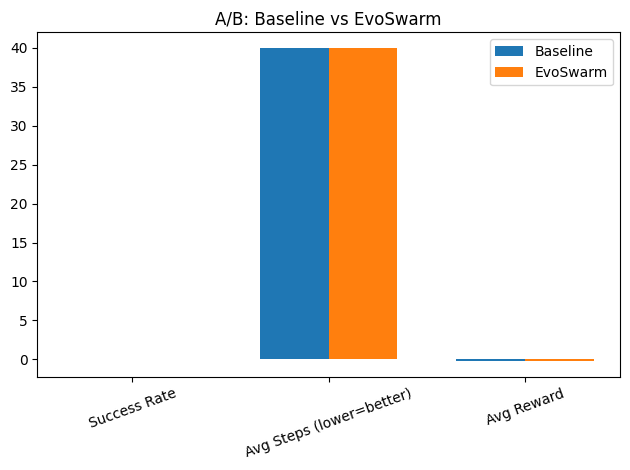

Saved logs to /mnt/data/ab_logs/


In [ ]:

def run_ab_test(N=20, max_steps=40, pop_size=8):
    base_metrics = []
    for i in range(N):
        env = ToyIF()
        out = run_episode_baseline(env, BASELINE_GENOME, max_steps=max_steps)
        out["episode"] = i; out["agent"]="baseline"
        base_metrics.append(out)

    pop = [random_genome() for _ in range(pop_size-1)] + [copy.deepcopy(BASELINE_GENOME)]
    elites = MAPElites(bins=4)
    evo_metrics = []
    for i in range(N):
        env = ToyIF()
        out = run_episode_evoswarm(env, pop, elites, max_steps=max_steps, step_swarm_K=5)
        out["episode"] = i; out["agent"]="evoswarm"
        evo_metrics.append(out)
        pop = evolve_population(pop, elites, pop_size=pop_size)

    df_base = pd.DataFrame(base_metrics)
    df_evo = pd.DataFrame(evo_metrics)
    return df_base, df_evo

df_base, df_evo = run_ab_test(N=20, max_steps=40, pop_size=8)

def summarize(df):
    return {
        "success_rate": float((df["done"]==True).mean()),
        "avg_steps": float(df["steps"].mean()),
        "avg_reward": float(df["reward"].mean())
    }

summary_base = summarize(df_base)
summary_evo = summarize(df_evo)
print("Baseline:", summary_base)
print("EvoSwarm:", summary_evo)

import os
os.makedirs("/mnt/data/ab_logs", exist_ok=True)
df_base.to_csv("/mnt/data/ab_logs/baseline_smolllm.csv", index=False)
df_evo.to_csv("/mnt/data/ab_logs/evoswarm_smolllm.csv", index=False)

plt.figure()
labels = ["Success Rate","Avg Steps (lower=better)","Avg Reward"]
base_vals = [summary_base["success_rate"], summary_base["avg_steps"], summary_base["avg_reward"]]
evo_vals  = [summary_evo["success_rate"], summary_evo["avg_steps"], summary_evo["avg_reward"]]
x = np.arange(len(labels)); w = 0.35
plt.bar(x - w/2, base_vals, width=w, label="Baseline")
plt.bar(x + w/2, evo_vals, width=w, label="EvoSwarm")
plt.xticks(x, labels, rotation=20); plt.legend(); plt.title("A/B: Baseline vs EvoSwarm")
plt.tight_layout(); plt.show()

print("Saved logs to /mnt/data/ab_logs/")



## 7) Quick Trajectory Peek


In [ ]:

def preview_runs(df, k=3):
    sample = df.sample(min(k, len(df)), random_state=RANDOM_SEED)
    for _, row in sample.iterrows():
        print("Episode:", int(row["episode"]))
        print("  Agent:", row["agent"], "Done:", bool(row["done"]), "Steps:", int(row["steps"]), "Reward:", round(float(row["reward"]),3))
        print("  Exploration:", round(float(row["exploration"]),2), "Tool-use:", round(float(row["tool_use"]),2))
        print("  Actions:", row["actions"][:20], "...")
        print("-"*60)

print("=== Baseline examples ===")
preview_runs(df_base, k=3)
print("\n=== EvoSwarm examples ===")
preview_runs(df_evo, k=3)


=== Baseline examples ===
Episode: 0
  Agent: baseline Done: False Steps: 40 Reward: -0.23
  Exploration: 0.67 Tool-use: 1.0
  Actions: ['east', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key'] ...
------------------------------------------------------------
Episode: 17
  Agent: baseline Done: False Steps: 40 Reward: -0.23
  Exploration: 0.67 Tool-use: 1.0
  Actions: ['east', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key', 'take key'] ...
------------------------------------------------------------
Episode: 15
  Agent: baseline Done: False Steps: 40 Reward: -0.22
  Exploration: 0.67 Tool-use: 1.0
  Actions: ['look', 'east', 'take key', 'take key